# Setup

In [1]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [8]:
# load baselines: filename!!
with open('results/baselines_freeze_True_pool_False_lr_0.001_MNIST_to_Fashion.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results/results_freeze_True_reinit_False_pool_False_MNIST_to_Fashion.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.00,0.624650
1,0.001,0.001,-1,1,1.00,0.619850
2,0.001,0.001,-1,2,0.82,0.561200
3,0.001,0.001,-1,3,0.74,0.639417
4,0.001,0.001,-1,4,0.94,0.576700


In [6]:
# Filter the baselines to these percentages: 0.001, 0.01, 0.1, 0.5, 1.0
# because there are some extra percentages
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]
data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.00,0.624650
1,0.001,0.001,-1,1,1.00,0.619850
2,0.001,0.001,-1,2,0.82,0.561200
3,0.001,0.001,-1,3,0.74,0.639417
4,0.001,0.001,-1,4,0.94,0.576700


In [11]:
# OR LOAD ARI Scores
with open("results/ari_scores/ari_scores_finetuned_MNIST_to_Fashion.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()

,Percentage,Repeat,Num Samples,Layer,Max ARI Score,Avg ARI Score,Dataset,Split
0,0.001,0,0,conv0,38.638659,22.479358,Finetune,Train
1,0.001,0,0,conv1,35.315045,20.162059,Finetune,Train
2,0.001,0,0,conv2,36.774194,19.777657,Finetune,Train
3,0.001,0,0,conv3,34.943236,19.721425,Finetune,Train
4,0.001,0,0,conv4,39.666604,20.522841,Finetune,Train


# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

<module 'matplotlib.pyplot' from '/home/arnisa/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

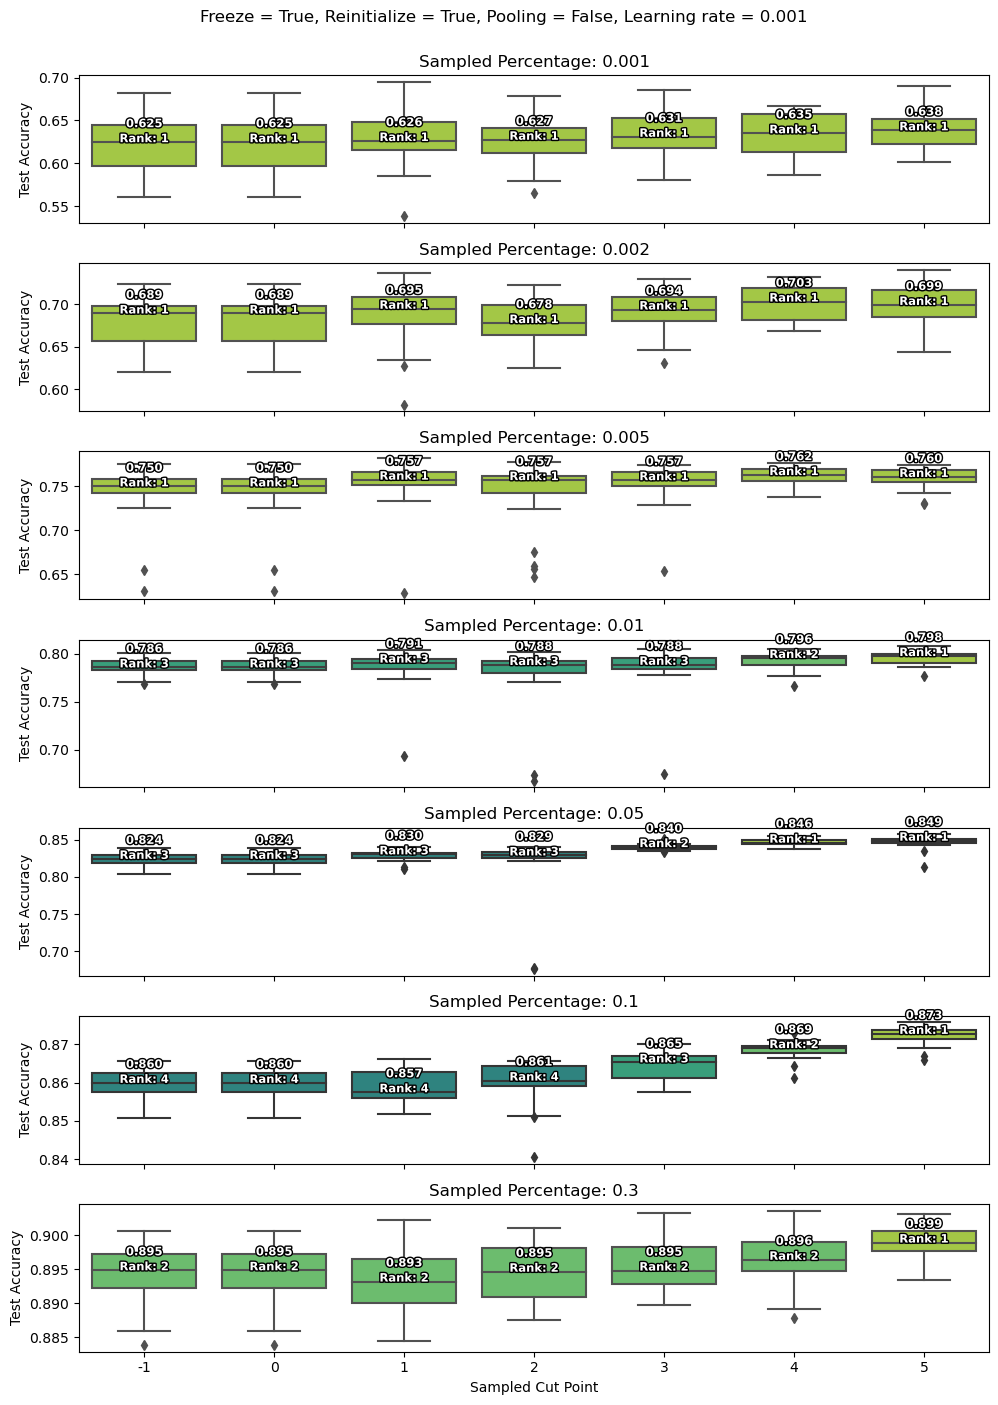

In [9]:
# run statistical tests below to get the df_rankings
df_rankings = pairwise_comparison(df=df)
box_plot_percentages_experiments(df=df, rank_df=df_rankings, color_ranks=True, params=params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

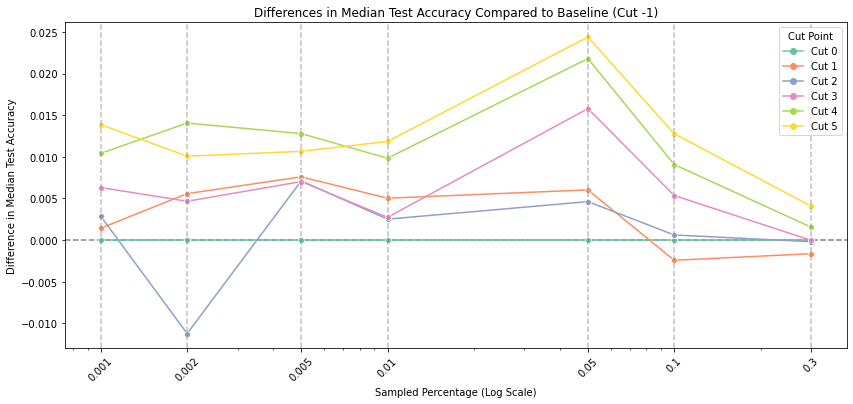

In [4]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

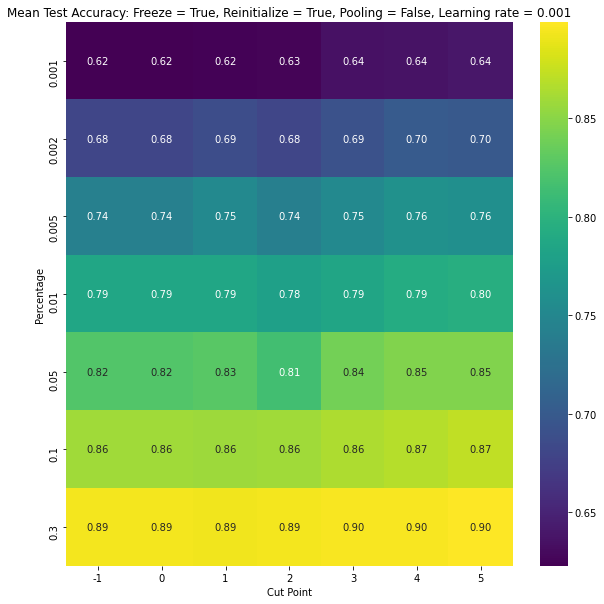

In [5]:
heatmap(df, params, figsize=(10,10))

### ARI Scores Plots

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

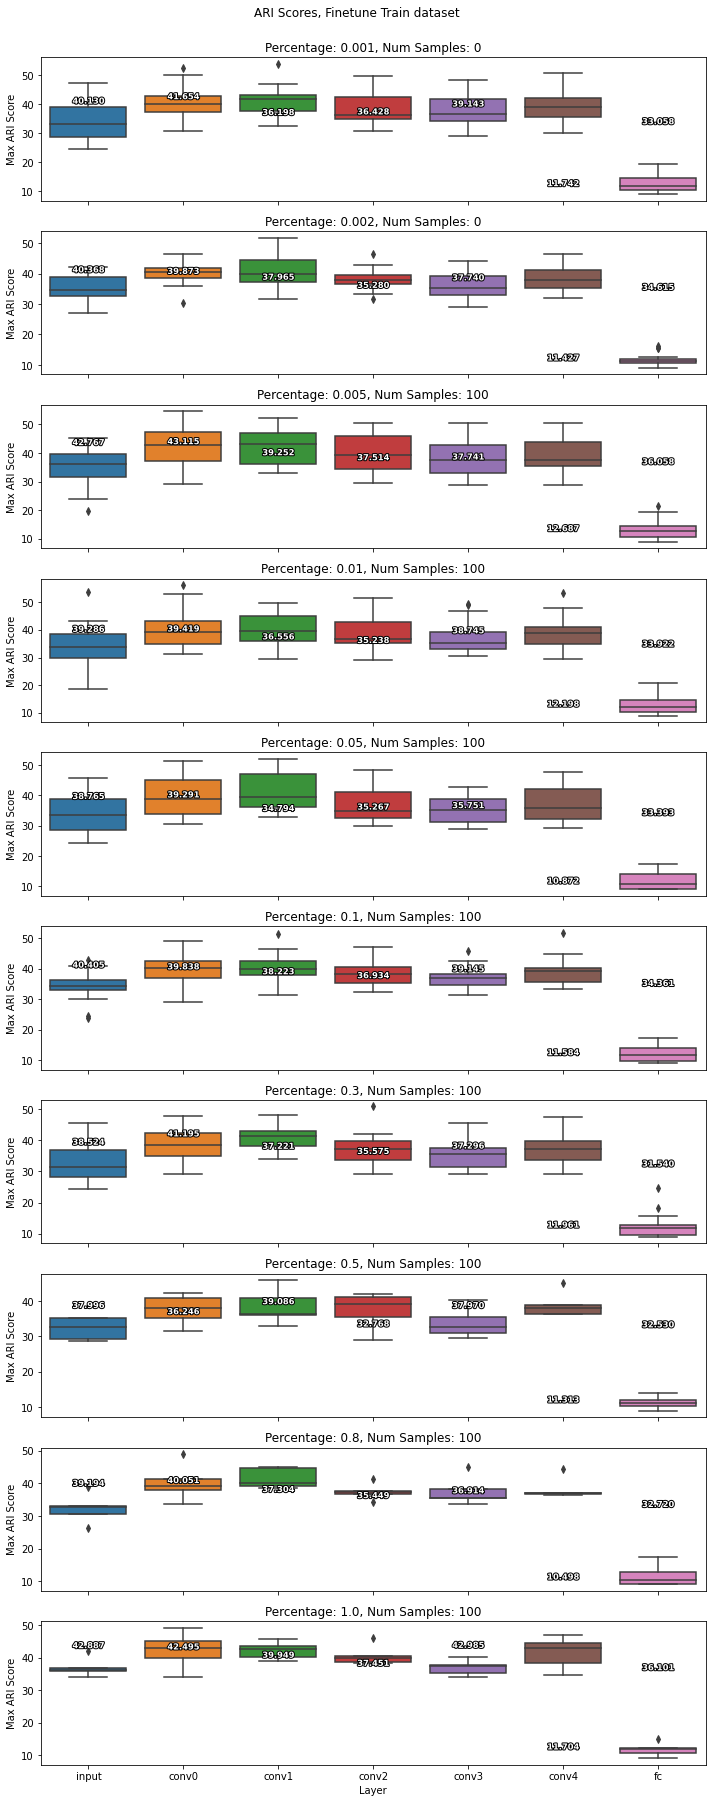

In [12]:
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']
plot_ARI_scores_percentages(df_ari, dataset="Finetune", split="Train", order=layer_names, figsize=(10,25))

# 2. Statistical Tests

### Ranking Cuts

In [8]:
from scipy.stats import wilcoxon

# Assuming df_combined is your original DataFrame
df_differences = df[df['Cut Point'] != -1]

def perform_wilcoxon_test(group, cut_point_1, cut_point_2):
    data_1 = group[group['Cut Point'] == cut_point_1]['Test Accuracy']
    data_2 = group[group['Cut Point'] == cut_point_2]['Test Accuracy']

    # Ensure equal length by trimming or padding
    min_len = min(len(data_1), len(data_2))
    data_1, data_2 = data_1[:min_len], data_2[:min_len]

    stat, p_value = wilcoxon(data_1, data_2)
    return stat, p_value

# Perform pairwise comparison for each sampled_percentage
wilcoxon_pairwise_results = []

for percentage in df_differences['Percentage'].unique():
    group = df_differences[df_differences['Percentage'] == percentage]
    cut_points = group['Cut Point'].unique()

    for i in range(len(cut_points)):
        for j in range(i + 1, len(cut_points)):
            stat, p_value = perform_wilcoxon_test(group, cut_points[i], cut_points[j])
            wilcoxon_pairwise_results.append({
                'Percentage': percentage,
                'Cut Point 1': cut_points[i],
                'Cut Point 2': cut_points[j],
                'statistic': stat,
                'p_value': p_value
            })

# Converting the results to a DataFrame
df_wilcoxon_pairwise = pd.DataFrame(wilcoxon_pairwise_results)

In [9]:
import pandas as pd

# Assuming df_wilcoxon_pairwise and df_differences are defined as before

# Step 1: Aggregate Test Accuracy and Initialize Rankings
median_accuracy = df_differences.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].median()

rankings = {percentage: {} for percentage in median_accuracy.index.get_level_values(0).unique()}
for (percentage, cut_point), accuracy in median_accuracy.items():
    rankings[percentage][cut_point] = {'median_accuracy': accuracy, 'rank': None, 'group': set([cut_point])}

# Step 2: Group Cuts Based on Statistical Significance
alpha = 0.05  # Significance level

for percentage, cuts_info in rankings.items():
    for cut1, info1 in cuts_info.items():
        for cut2, info2 in cuts_info.items():
            if cut1 != cut2:
                wilcoxon_row = df_wilcoxon_pairwise[
                    (df_wilcoxon_pairwise['Percentage'] == percentage) & 
                    ((df_wilcoxon_pairwise['Cut Point 1'] == cut1) & (df_wilcoxon_pairwise['Cut Point 2'] == cut2) |
                     (df_wilcoxon_pairwise['Cut Point 1'] == cut2) & (df_wilcoxon_pairwise['Cut Point 2'] == cut1))
                ]
                if not wilcoxon_row.empty and wilcoxon_row.iloc[0]['p_value'] > alpha:
                    # Merge groups if not significantly different
                    info1['group'].update(info2['group'])
                    for cut in info2['group']:
                        info1['group'].update(rankings[percentage][cut]['group'])
                    for cut in info1['group']:
                        rankings[percentage][cut]['group'] = info1['group']

# Step 3: Assign Ranks with Ties
for percentage, cuts_info in rankings.items():
    sorted_groups = sorted({frozenset(info['group']) for cut, info in cuts_info.items()}, key=lambda x: min(median_accuracy[percentage, cut] for cut in x), reverse=True)
    rank = 1
    for group in sorted_groups:
        for cut in group:
            rankings[percentage][cut]['rank'] = rank
        rank += len(group)

# Convert rankings and median accuracies to a DataFrame for easier visualization
df_rankings = pd.DataFrame([(percentage, cut, data['rank'], data['median_accuracy']) for percentage, cuts_info in rankings.items() for cut, data in cuts_info.items()],
                           columns=['Percentage', 'Cut Point', 'rank', 'median_accuracy'])


In [10]:
df_rankings

,Percentage,Cut Point,rank,median_accuracy
0,0.001,0,1,0.624650
1,0.001,1,1,0.626067
2,0.001,2,1,0.627483
3,0.001,3,1,0.630950
4,0.001,4,1,0.635067
5,0.001,5,1,0.638500
6,0.002,0,1,0.689017
7,0.002,1,1,0.694583
8,0.002,2,1,0.677767
9,0.002,3,1,0.693667
